# Import libraries

In [53]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import squarify

# Import Data

In [54]:
#Import Data
purchase= pd.read_csv("./purchase_data.csv" ,index_col=0)

In [55]:
purchase.head()

,Invoice_Id,Amount,Purchase_Date,Customer_Id
0,272352054.0,140.01,2019-05-05,Customer: 1
1,299813385.0,37.44,2019-11-16,Customer: 1
2,313339477.0,26.93,2020-03-06,Customer: 2
3,315150354.0,27.40,2020-03-22,Customer: 2
4,305737473.0,28.42,2019-12-13,Customer: 3


In [56]:
purchase.shape

(971102, 4)

In [10]:
#Check unique number of values for each column
def unique_counts(purchase):
    for i in purchase.columns:
        count = purchase[i].nunique()
        print(i," :", count)
unique_counts(purchase)

Invoice_Id  : 644545
Amount  : 30214
Purchase_Date  : 423
Customer_Id  : 338190


In [11]:
#Easy way to check the number of unique values
purchase.nunique()

Invoice_Id       644545
Amount            30214
Purchase_Date       423
Customer_Id      338190
dtype: int64

In [12]:
#Check all the data types
purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971102 entries, 0 to 971101
Data columns (total 4 columns):
Invoice_Id       970778 non-null float64
Amount           971102 non-null float64
Purchase_Date    971102 non-null object
Customer_Id      971102 non-null object
dtypes: float64(2), object(2)
memory usage: 37.0+ MB


In [13]:
#Converting the 'Purchase_Date' type into datetime
purchase['Purchase_Date'] = pd.to_datetime(purchase['Purchase_Date'])

In [14]:
purchase.dtypes

Invoice_Id              float64
Amount                  float64
Purchase_Date    datetime64[ns]
Customer_Id              object
dtype: object

# RFM Customer Segmentation

In [15]:
#RFM segmentation starts from here
from datetime import date
now = date.today()
print(now)

2020-06-18


# RFM Table

In [16]:
#create a RFM table
rfmTable = purchase.groupby('Customer_Id').agg({'Purchase_Date': 
                                                           lambda Date:(now - Date.max().date()).days,
                                                            'Invoice_Id': lambda x: len(x),
                                                            'Amount': lambda Amount: Amount.sum()})

In [17]:
rfmTable.head(3)

,Purchase_Date,Invoice_Id,Amount
Customer_Id,,,
Customer: 1,215,2.0,177.45
Customer: 10,258,6.0,176.44
Customer: 100,27,2.0,34.56


In [18]:
rfmTable.reset_index(inplace=True)

# Recency , Frequency & Monetary Value

In [19]:
#Renaming the columns to the appropriate names
#Recency — number of days since the last purchase
#Frequency — number of transactions made over a given period
#Monetary — amount spent over a given period of time
rfmTable.rename(columns = {'Purchase_Date' : 'Recency',
                           'Invoice_Id' : 'Frequency',
                           'Amount' : 'Monetary_Value'},inplace = True) 

In [20]:
rfmTable.head(3)

,Customer_Id,Recency,Frequency,Monetary_Value
0,Customer: 1,215,2.0,177.45
1,Customer: 10,258,6.0,176.44
2,Customer: 100,27,2.0,34.56


In [21]:
##pip install chart_studio

In [22]:
##rfmTable.iplot(kind = 'scatter', x = 'Recency', y = 'Customer_Id', mode = 'markers', size = 5)

In [23]:
##sns.distplot(rfmTable['Recency'], kde = False , bins = 40)

In [24]:
##sns.distplot(rfmTable['Monetary_Value'], kde = False , bins = 10)

##plt.xlim(0, 100)

In [25]:
# sns.distplot(rfmTable['Recency'], kde = False)

In [26]:
# sns.distplot(rfmTable['Frequency'], kde = False , bins = 1000)
# ##sns.plt.ylim(0, 20)
# plt.xlim(0, 30)

In [27]:
# sns.distplot(rfmTable['Monetary_Value'], kde = False , bins = 1000)
# plt.xlim(0, 2000)

In [28]:
#Split the metrics into segments by using quartiles
quantiles =  rfmTable.quantile(q = [0.25,0.5,0.75])
quantiles = quantiles.to_dict()
print(quantiles)

{'Recency': {0.25: 63.0, 0.5: 184.0, 0.75: 246.0}, 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0}, 'Monetary_Value': {0.25: 45.68, 0.5: 92.39, 0.75: 190.3}}


# Segmented RFM Table

In [29]:
#create a segmented RFM Table
segmented_rfm = rfmTable
segmented_rfm.head()

,Customer_Id,Recency,Frequency,Monetary_Value
0,Customer: 1,215,2.0,177.45
1,Customer: 10,258,6.0,176.44
2,Customer: 100,27,2.0,34.56
3,Customer: 1000,270,1.0,47.43
4,Customer: 10000,20,3.0,98.53


In [30]:
#logic to define the best customers
#The lowest recency, highest frequency and monetary amounts are our best customers.
def RScore(x,d):
    if x <= d['Recency'][0.25]:
        return 1
    elif x<= d['Recency'][0.50]:
        return 2
    elif x<= d['Recency'][0.75]:
        return 3
    else:
        return 4
    
def FScore(x,d):
    if x <= d['Frequency'][0.25]:
        return 4
    elif x<= d['Frequency'][0.50]:
        return 3
    elif x<= d['Frequency'][0.75]:
        return 2
    else:
        return 1

def MScore(x,d):
    if x <= d['Monetary_Value'][0.25]:
        return 4
    elif x<= d['Monetary_Value'][0.50]:
        return 3
    elif x<= d['Monetary_Value'][0.75]:
        return 2
    else:
        return 1

    

In [31]:
#Add segment numbers to the newly created segmented RFM table
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore,args=(quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(FScore,args=(quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary_Value'].apply(MScore,args=(quantiles,))
segmented_rfm.head()

,Customer_Id,Recency,Frequency,Monetary_Value,r_quartile,f_quartile,m_quartile
0,Customer: 1,215,2.0,177.45,3,3,2
1,Customer: 10,258,6.0,176.44,4,1,2
2,Customer: 100,27,2.0,34.56,1,3,4
3,Customer: 1000,270,1.0,47.43,4,4,3
4,Customer: 10000,20,3.0,98.53,1,2,2


# RFM Distribution Plots

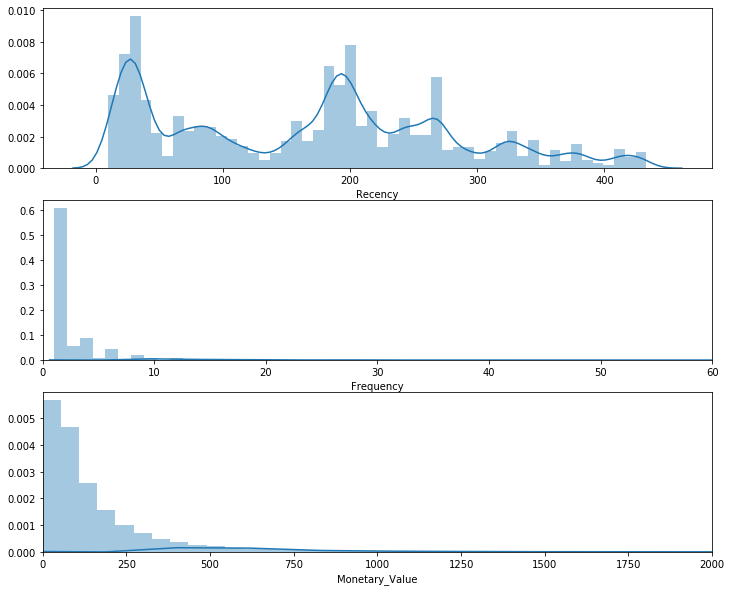

In [32]:
plt.figure(figsize=(12,10))
# Plot distribution of Recency
plt.subplot(3, 1, 1); sns.distplot(segmented_rfm['Recency'])
# Plot distribution of Frequency
plt.subplot(3, 1, 2); sns.distplot(segmented_rfm['Frequency'] , bins = 500)
plt.xlim(0, 60)
# Plot distribution of Monetary_Value
plt.subplot(3, 1, 3); sns.distplot(segmented_rfm['Monetary_Value'], bins = 500)
plt.xlim(0, 2000)
# Show the plot
plt.show()

# Create RFM Segments

In [33]:
#Combine RFM Segment
segmented_rfm['RFM_Segment'] = segmented_rfm.r_quartile.map(str)+segmented_rfm.f_quartile.map(str)+segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,Customer_Id,Recency,Frequency,Monetary_Value,r_quartile,f_quartile,m_quartile,RFM_Segment
0,Customer: 1,215,2.0,177.45,3,3,2,332
1,Customer: 10,258,6.0,176.44,4,1,2,412
2,Customer: 100,27,2.0,34.56,1,3,4,134
3,Customer: 1000,270,1.0,47.43,4,4,3,443
4,Customer: 10000,20,3.0,98.53,1,2,2,122


# RFM Score

In [34]:
# Summing the Score
# Calculate RFM_Score
segmented_rfm['RFM_Score'] = segmented_rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
segmented_rfm.head()

,Customer_Id,Recency,Frequency,Monetary_Value,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
0,Customer: 1,215,2.0,177.45,3,3,2,332,8
1,Customer: 10,258,6.0,176.44,4,1,2,412,7
2,Customer: 100,27,2.0,34.56,1,3,4,134,8
3,Customer: 1000,270,1.0,47.43,4,4,3,443,11
4,Customer: 10000,20,3.0,98.53,1,2,2,122,5


In [35]:
# Count number of unique segments(RFM_Segment)
rfm_count_unique = segmented_rfm.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

64


In [36]:
segmented_rfm.nunique()

Customer_Id       338190
Recency              423
Frequency            100
Monetary_Value     75081
r_quartile             4
f_quartile             4
m_quartile             4
RFM_Segment           64
RFM_Score             10
dtype: int64

# Top 10 Best Customers

In [37]:
#Who are the top 10 of our best customers!
segmented_rfm[segmented_rfm['RFM_Segment']=='111'].sort_values('Monetary_Value', ascending=False).head(10)

,Customer_Id,Recency,Frequency,Monetary_Value,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
16455,Customer: 114807,21,182.0,27211.48,1,1,1,111,3
328338,Customer: 91130,14,580.0,23796.78,1,1,1,111,3
53869,Customer: 148480,22,42.0,22455.60,1,1,1,111,3
34160,Customer: 130741,32,51.0,9867.15,1,1,1,111,3
275370,Customer: 4346,17,192.0,9725.61,1,1,1,111,3
273846,Customer: 42088,33,120.0,8392.08,1,1,1,111,3
321306,Customer: 84802,23,57.0,7618.65,1,1,1,111,3
73950,Customer: 166553,59,66.0,7609.50,1,1,1,111,3
274891,Customer: 43028,18,45.0,6357.84,1,1,1,111,3
61594,Customer: 155432,10,232.0,5834.36,1,1,1,111,3


In [38]:
segmented_rfm.head(3)

,Customer_Id,Recency,Frequency,Monetary_Value,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
0,Customer: 1,215,2.0,177.45,3,3,2,332,8
1,Customer: 10,258,6.0,176.44,4,1,2,412,7
2,Customer: 100,27,2.0,34.56,1,3,4,134,8


In [39]:
segmented_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338190 entries, 0 to 338189
Data columns (total 9 columns):
Customer_Id       338190 non-null object
Recency           338190 non-null int64
Frequency         338190 non-null float64
Monetary_Value    338190 non-null float64
r_quartile        338190 non-null int64
f_quartile        338190 non-null int64
m_quartile        338190 non-null int64
RFM_Segment       338190 non-null object
RFM_Score         338190 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 23.2+ MB


In [40]:
# # Define Segment_Level function
# def Segment_Level(segmented_rfm):
#     if (segmented_rfm['RFM_Segment'] == '111'):
#         return 'Best Customers'
    
#     elif segmented_rfm['RFM_Segment'] == '444': 
#         return 'Lost Cheap Customers' 
    
#     elif segmented_rfm['RFM_Segment'] == '311': 
#         return 'Almost Lost' 
    
#     elif segmented_rfm['RFM_Segment'] == '411': 
#         return 'Lost Customers'   
    
#     elif segmented_rfm['RFM_Segment'][1] == '1' and not segmented_rfm['RFM_Segment'] == '111' and not segmented_rfm['RFM_Segment'][1:] == '13'and not segmented_rfm['RFM_Segment'][1:] == '14'and not segmented_rfm['RFM_Segment'] == '311' and not segmented_rfm['RFM_Segment'] == '411':
#         return 'Loyal Customers'
    
#     elif segmented_rfm['RFM_Segment'][2] == '1' and not segmented_rfm['RFM_Segment'] == '111' and not segmented_rfm['RFM_Segment'] == '311' and not segmented_rfm['RFM_Segment'] == '411':
#         return 'Big Spenders'
    
#     elif segmented_rfm['RFM_Segment'][1:] == '13' or segmented_rfm['RFM_Segment'][1:] == '14':
#         return 'Faithful customers'
    
#     elif segmented_rfm['RFM_Segment'][0:1] == '14': 
#         return 'Rookies-Newest Customers'
    
#     elif segmented_rfm['RFM_Segment'][0:1] == '44' and not segmented_rfm['RFM_Segment'] == '444': 
#         return 'Slipping-Once Loyal, Now Gone'
    
#     else:
#         return 'Others'

# Segment Level

In [41]:
# Define Segment_Level function
def Segment_Level(segmented_rfm):
    if (segmented_rfm['RFM_Segment'] == '111'):
        return 'Champions'
    
    elif segmented_rfm['RFM_Segment'] in ['112','211','121']: 
        return 'Loyal Customers' 
    
    elif segmented_rfm['RFM_Segment'] in ['131','141']: 
        return 'Potential Loyalist' 
    
    elif segmented_rfm['RFM_Segment'] in ['142','143','144']: 
        return 'Recent Customers'   
    
    elif segmented_rfm['RFM_Segment'] in ['221','222','122','212','123','132','213','231','321','312','223','322','232']: 
        return 'Promising'
    
    elif segmented_rfm['RFM_Segment'] in ['431','341']: 
        return 'Needs Attention'
    
    elif segmented_rfm['RFM_Segment'] in ['332','333','331','313','323','343','233']: 
        return 'About to Sleep'
    
    elif segmented_rfm['RFM_Segment'] in ['114','113','124','213','214']: 
        return 'Price Sensitive'
    
    elif segmented_rfm['RFM_Segment'] in ['411','421','311']: 
        return 'Cant Lose Them'
    
    elif segmented_rfm['RFM_Segment'] in ['433','434' ,'443','344', '334']: 
        return 'Hibernating'
    
    elif segmented_rfm['RFM_Segment'] in ['444']: 
        return 'Lost'
    
    else:
        return 'Others'
               
    
# Create a new variable RFM_Level
segmented_rfm['Segment_Level'] = segmented_rfm.apply(Segment_Level, axis=1)


# Print the header with top 5 rows to the console
segmented_rfm.head()

,Customer_Id,Recency,Frequency,Monetary_Value,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score,Segment_Level
0,Customer: 1,215,2.0,177.45,3,3,2,332,8,About to Sleep
1,Customer: 10,258,6.0,176.44,4,1,2,412,7,Others
2,Customer: 100,27,2.0,34.56,1,3,4,134,8,Others
3,Customer: 1000,270,1.0,47.43,4,4,3,443,11,Hibernating
4,Customer: 10000,20,3.0,98.53,1,2,2,122,5,Promising


In [42]:
segmented_rfm.to_csv('segmented_rfm.csv')

In [43]:
# Calculate average values for each Segment_Name, and return a size of each segment 
rfm_level_agg = segmented_rfm.groupby('Segment_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary_Value       
                      mean      mean           mean  count
Segment_Level                                             
About to Sleep       192.7       1.9          105.9  45026
Cant Lose Them       245.6       6.3          450.2  18396
Champions             29.8       9.6          537.8  17564
Hibernating          268.2       1.4           44.2  50154
Lost                 325.5       1.0           26.4  18388
Loyal Customers       92.2       7.2          414.7  25831
Needs Attention      295.0       1.9          304.0   7371
Others               175.1       1.7           86.4  73954
Potential Loyalist    32.0       1.9          286.6   5325
Price Sensitive       37.5       4.3           55.5   2844
Promising            111.4       3.0          160.9  48355
Recent Customers      29.0       1.0           55.5  24982


In [44]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()

In [45]:
print(rfm_level_agg)

                     mean  mean   mean  count
Segment_Level                                
About to Sleep      192.7   1.9  105.9  45026
Cant Lose Them      245.6   6.3  450.2  18396
Champions            29.8   9.6  537.8  17564
Hibernating         268.2   1.4   44.2  50154
Lost                325.5   1.0   26.4  18388
Loyal Customers      92.2   7.2  414.7  25831
Needs Attention     295.0   1.9  304.0   7371
Others              175.1   1.7   86.4  73954
Potential Loyalist   32.0   1.9  286.6   5325
Price Sensitive      37.5   4.3   55.5   2844
Promising           111.4   3.0  160.9  48355
Recent Customers     29.0   1.0   55.5  24982


In [46]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

In [47]:
print(rfm_level_agg)

                    RecencyMean  FrequencyMean  MonetaryMean  Count
Segment_Level                                                      
About to Sleep            192.7            1.9         105.9  45026
Cant Lose Them            245.6            6.3         450.2  18396
Champions                  29.8            9.6         537.8  17564
Hibernating               268.2            1.4          44.2  50154
Lost                      325.5            1.0          26.4  18388
Loyal Customers            92.2            7.2         414.7  25831
Needs Attention           295.0            1.9         304.0   7371
Others                    175.1            1.7          86.4  73954
Potential Loyalist         32.0            1.9         286.6   5325
Price Sensitive            37.5            4.3          55.5   2844
Promising                 111.4            3.0         160.9  48355
Recent Customers           29.0            1.0          55.5  24982


# Plot the Heat Map

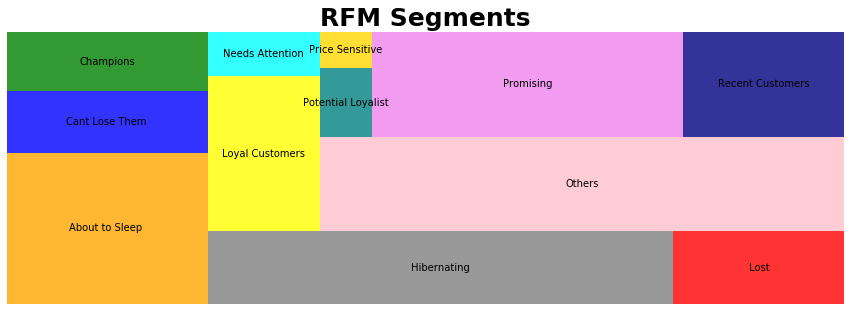

In [48]:
#Create the plot
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 5)

squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['About to Sleep ',
                     'Cant Lose Them ',
                     'Champions',
                     'Hibernating',
                     'Lost', 
                     'Loyal Customers', 
                     'Needs Attention',
                     'Others',
                     'Potential Loyalist', 
                     'Price Sensitive',
                     'Promising',
                     'Recent Customers'],color=["orange","blue","green","grey","red","yellow","Aqua","Pink","Teal","Gold","violet","navy"],alpha=.8 )

plt.title("RFM Segments",fontsize=25,fontweight="bold")
plt.axis('off')
plt.show()
